In [1]:
from collections import defaultdict
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import numpy as np
import pandas as pd
import seaborn as sns

In [56]:
def calc_gpu_memcpy_time(
        src_gpu, dst_gpu, buffer_size, 
        grid_size=128, block_size=256, 
        partition_num=8, copy_iter=5):
    bandwidth_mod = SourceModule("""
    __global__ void bandwidth_calc(
        float *src, float *dst, int buffer_size, int partition_num)
    {
        const int thread_idx = blockIdx.x * blockDim.x + threadIdx.x;
        const int grid_step = gridDim.x * blockDim.x;
        const int partition_size = buffer_size / partition_num; 

        for ( int th_idx = thread_idx; th_idx < partition_size; th_idx += grid_step ) 
        {
            for ( int idx = th_idx; idx < buffer_size; idx += partition_size ) 
            {
                dst[idx] += src[idx];
            }
        }
    }
    """)

    bandwidth_kernel = bandwidth_mod.get_function("bandwidth_calc")
    bandwidth_kernel.prepare("PPii")
    buf_num = buffer_size // 4

    times = list()
    for iter in range(copy_iter+1):
        ev_start  = drv.Event()
        ev_finish = drv.Event()

        ev_start.record()
        bandwidth_kernel.prepared_call(
            (grid_size,1), (block_size,1,1),
            src_gpu, dst_gpu, 
            np.int32(buf_num), np.int32(partition_num)
        )
        ev_finish.record()
        ev_finish.synchronize()

        time = ev_start.time_till(ev_finish) * 0.001
        if iter != 0:
            times.append(time)
    return times

In [109]:
def show_bandwidth(time_df, target="buffer_size"):
    mean_df = time_df.groupby([target], as_index=False).mean()

    band_dict = defaultdict(list)
    for row in mean_df.itertuples():
        # バイト数 * 読(1)書(1) / KB / MB / GB) / 平均 
        bandwidth = (row.buffer_size * 2 / 1024 / 1024 / 1024) / row.copy_time

        band_dict[target].append(getattr(row, target))
        band_dict["bandwidth"].append(bandwidth)
    band_df = pd.DataFrame(band_dict)

    ax = sns.catplot(x=target, y="bandwidth", data=band_df, kind="bar")
    ax = ax.set_xticklabels(rotation=90)
    return ax

## 1. 計測するバッファサイズ 

In [81]:
mem_step = 10
min_mem_size = 1024
max_mem_size = 1 * 1024 * 1024 * 1024

min_mem_log2 = np.log2(min_mem_size)
max_mem_log2 = np.log2(max_mem_size)

# step size: 10
print(f"{min_mem_log2} - {max_mem_log2}: {mem_step} step")


10.0 - 30.0: 10 step


In [82]:
devdat = pycuda.tools.DeviceData()
copy_buffers = np.logspace(min_mem_log2, max_mem_log2, mem_step, base=2)
copy_buffers_align = [devdat.align(buf, word_size = 4) for buf in copy_buffers]

In [83]:
copy_buffers_align

[1024,
 4800,
 22336,
 104064,
 485440,
 2265088,
 10569024,
 49316160,
 230114688,
 1073741824]

In [84]:
max_buffer_size = max(copy_buffers_align)
src_gpu = drv.mem_alloc(max_buffer_size)
dst_gpu = drv.mem_alloc(max_buffer_size)

## 2. メモリバンド幅の計測 (バッファサイズ別)

In [112]:
time_dict = defaultdict(list)
for buffer_size in copy_buffers_align:
    copy_times = calc_gpu_memcpy_time(src_gpu, dst_gpu, buffer_size)
    for iter, time in enumerate(copy_times):
        time_dict["buffer_size"].append(buffer_size)
        time_dict["iteration"].append(iter)
        time_dict["copy_time"].append(time)
time_df = pd.DataFrame(time_dict)

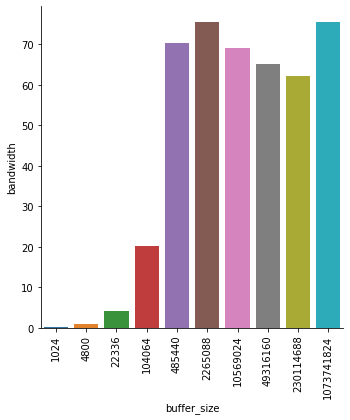

In [113]:
show_bandwidth(time_df, target="buffer_size")

## 3. 計測するスレッドサイズ

In [69]:
total_thread_num = 128 * 256
block_sizes = [64, 96, 128, 192, 256, 512, 1024]
grid_sizes = [total_thread_num // blk for blk in block_sizes]
largest_buffer_size = copy_buffers_align[-1]

## 4. メモリバンド幅の計測 (スレッドサイズ別)

In [106]:
time_dict = defaultdict(list)
for grid, block in zip(grid_sizes, block_sizes):
    copy_times = calc_gpu_memcpy_time(
                    src_gpu, dst_gpu, largest_buffer_size, 
                    grid_size=grid, block_size=block)
    for iter, time in enumerate(copy_times):
        time_dict["thread"].append(block)
        time_dict["buffer_size"].append(largest_buffer_size)
        time_dict["iteration"].append(iter)
        time_dict["copy_time"].append(time)
time_df = pd.DataFrame(time_dict)

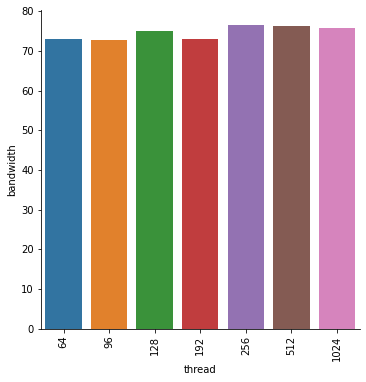

In [110]:
show_bandwidth(time_df, target="thread")